In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams["pdf.fonttype"] = 42 

In [3]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

In [4]:
from sklearn.svm import SVR

def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [5]:
adata = sc.read_10x_mtx("HS980_D38_Non_Replated/", cache=True)

In [6]:
adata

AnnData object with n_obs × n_vars = 1983 × 36601
    var: 'gene_ids', 'feature_types'

In [7]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

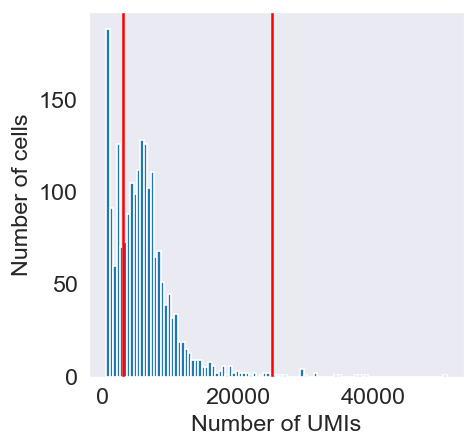

In [8]:
n, bins, *x = plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(3000, c="r")
plt.axvline(25000, c="r")
plt.show()

In [9]:
sc.pp.filter_cells(adata, min_counts=3000)
sc.pp.filter_cells(adata, max_counts=25000)

In [10]:
adata

AnnData object with n_obs × n_vars = 1433 × 36601
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types'

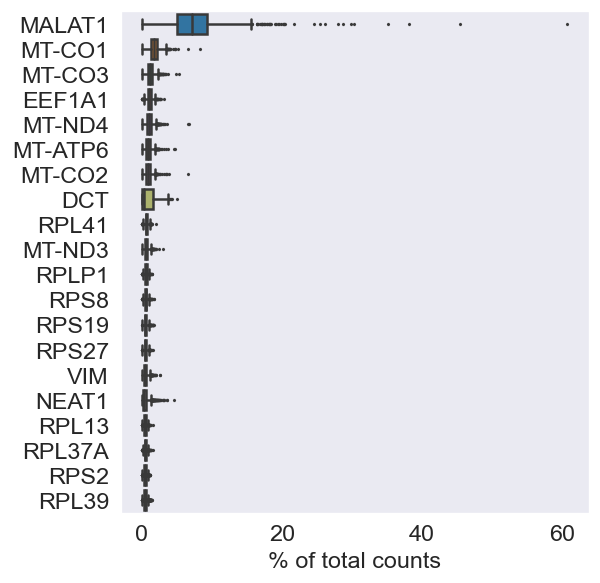

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)

1433

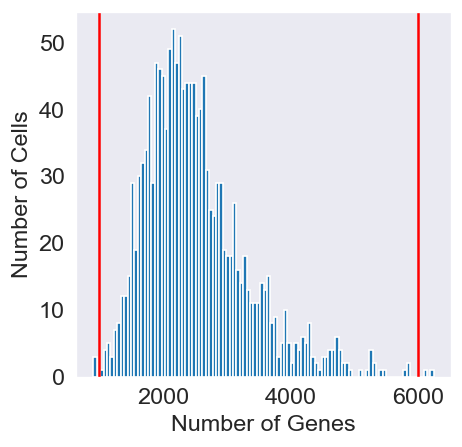

In [13]:
n, bins, *x = plt.hist(expressed_genes, bins=100)
plt.axvline(1000, c="r")
plt.axvline(6000, c="r")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

In [14]:
adata = adata[adata.obs['n_genes'] > 1000, :].copy()
adata = adata[adata.obs['n_genes'] < 6000, :].copy()

In [15]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [16]:
adata

AnnData object with n_obs × n_vars = 1428 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types'

... storing 'feature_types' as categorical


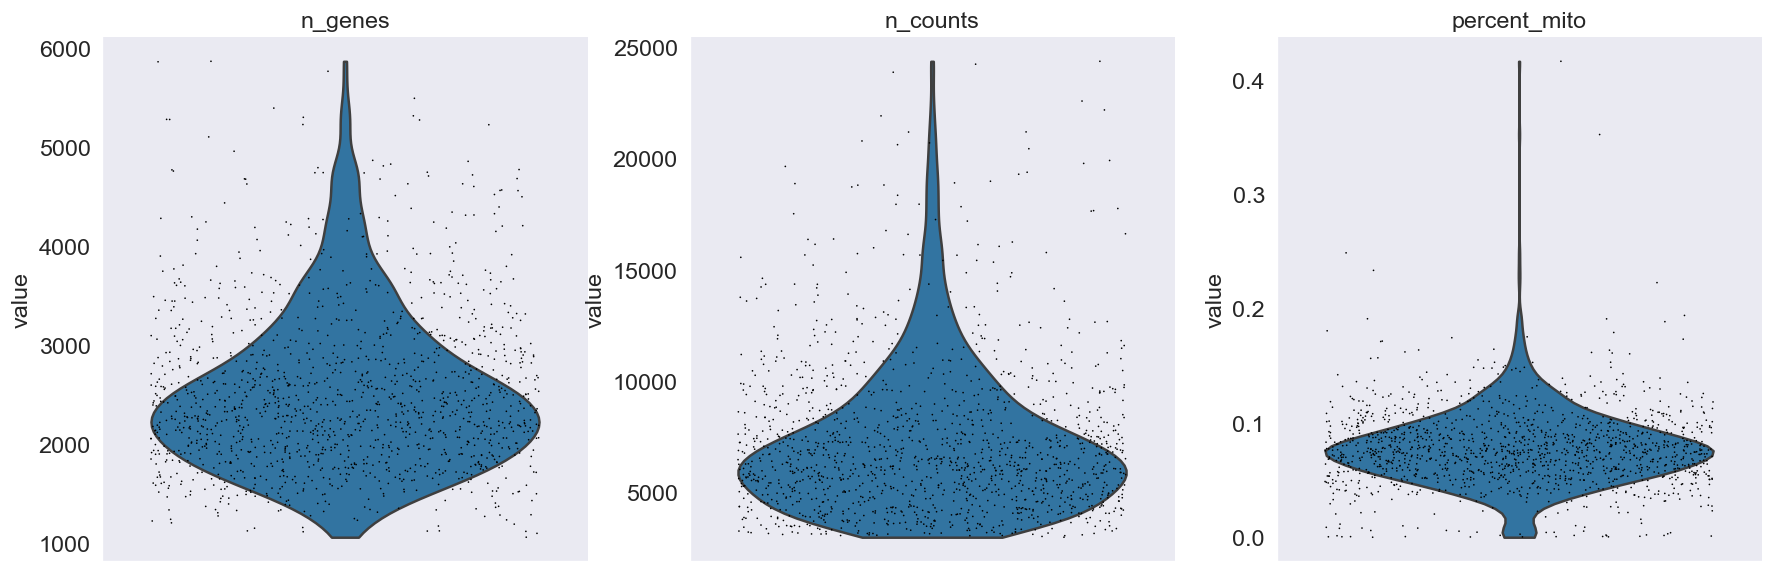

In [17]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

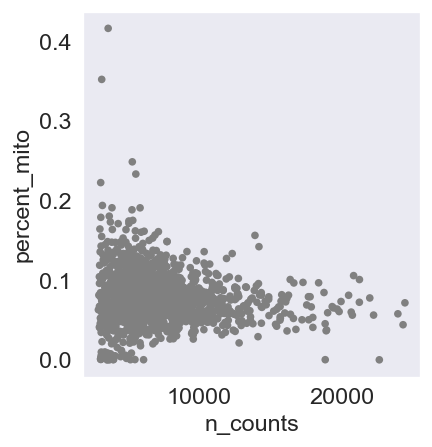

In [18]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [19]:
adata = adata[adata.obs['percent_mito'] < 0.20].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
adata_raw = adata.copy()

In [21]:
adata

AnnData object with n_obs × n_vars = 1423 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types'

In [22]:
sc.pp.filter_genes(adata, min_cells=20)

In [23]:
sc.pp.normalize_total(adata)

In [24]:
adata.raw = adata

In [25]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

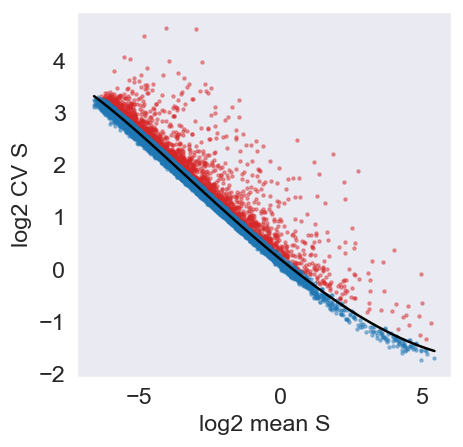

In [26]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.toarray().T, N=2000, max_expr_avg=50)

In [27]:
sc.pp.log1p(adata)

In [28]:
adata = adata[:, cv_vs_mean_keep].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [29]:
sc.pp.regress_out(adata, ['S_score'])

... storing 'phase' as categorical


In [30]:
sc.pp.regress_out(adata, ['G2M_score'])

In [31]:
sc.pp.scale(adata, max_value=10)

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

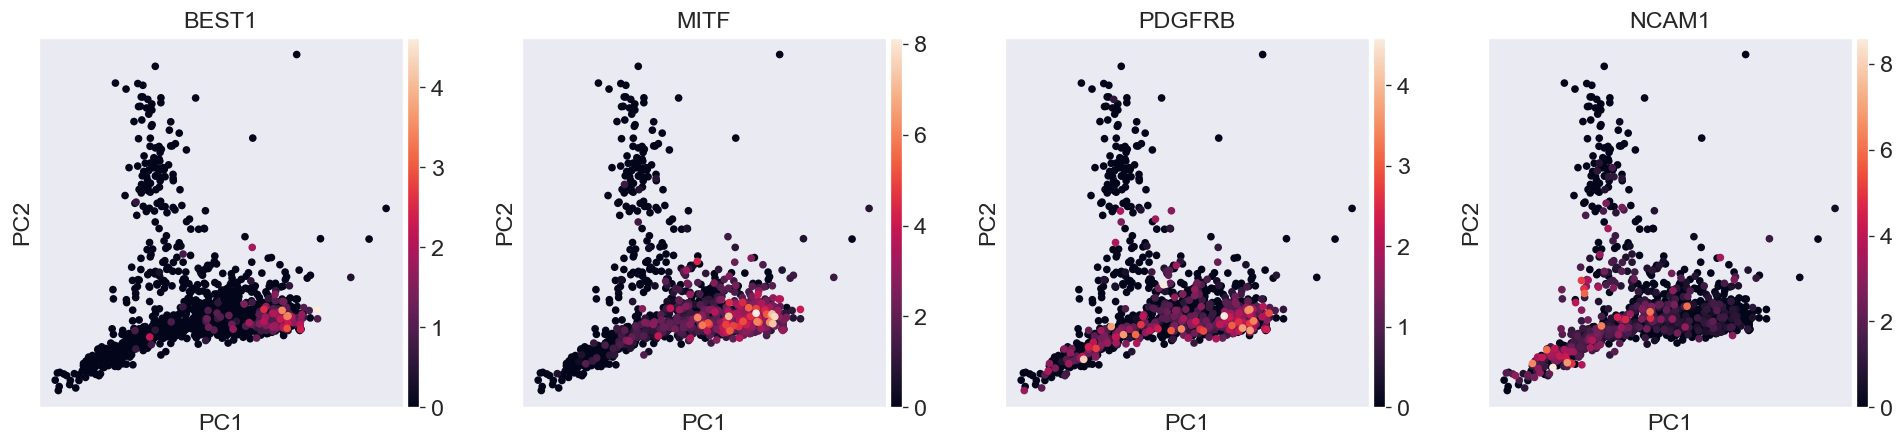

In [33]:
sc.pl.pca(adata, color=['BEST1', 'MITF', 'PDGFRB', 'NCAM1'])

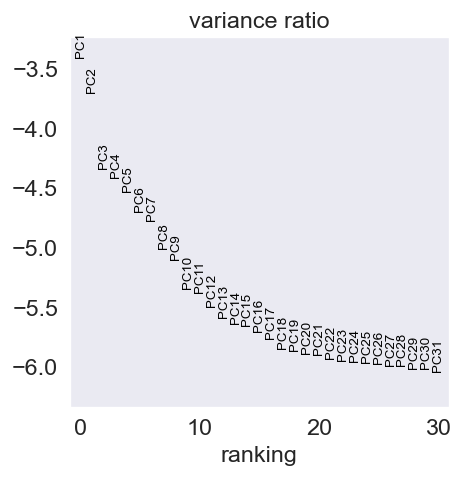

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)

In [36]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

In [37]:
sc.tl.louvain(adata, resolution=1)

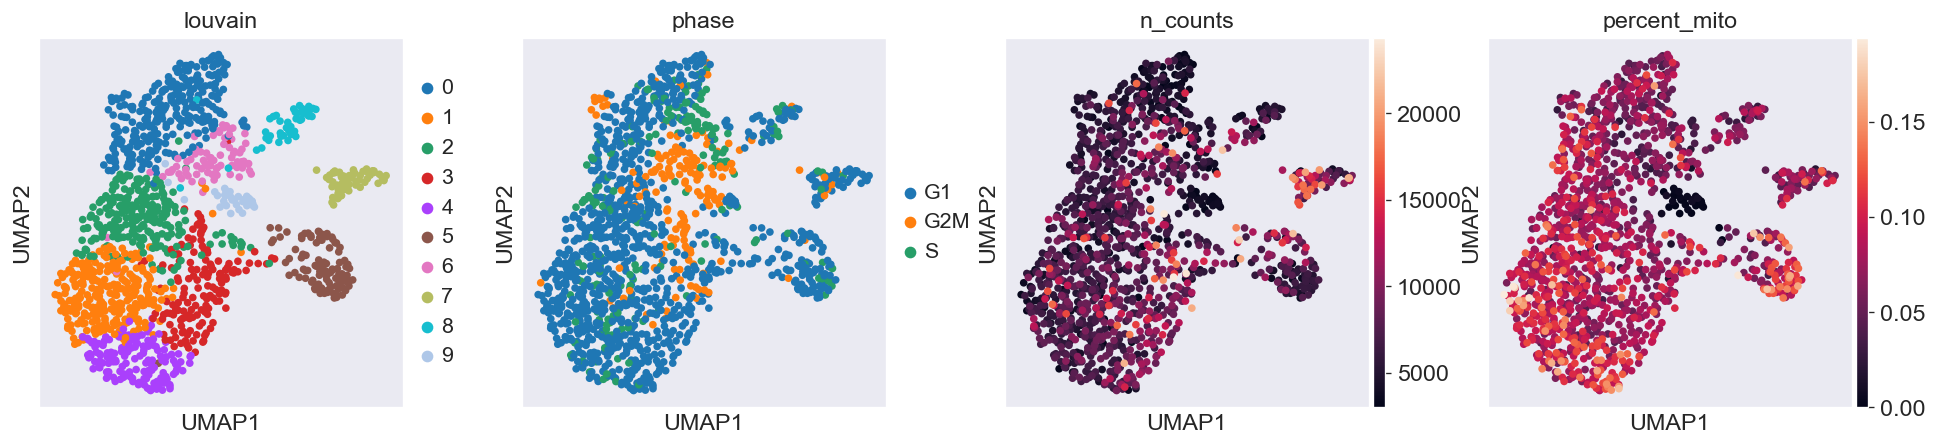

In [38]:
sc.pl.umap(adata, use_raw=True, color=['louvain', "phase", 'n_counts', 'percent_mito'], ncols=4)

In [39]:
adata_raw.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw.obs["louvain"] = adata.obs["louvain"]

In [40]:
adata_raw_norm = adata_raw.copy()
sc.pp.normalize_total(adata_raw_norm)
sc.pp.log1p(adata_raw_norm)

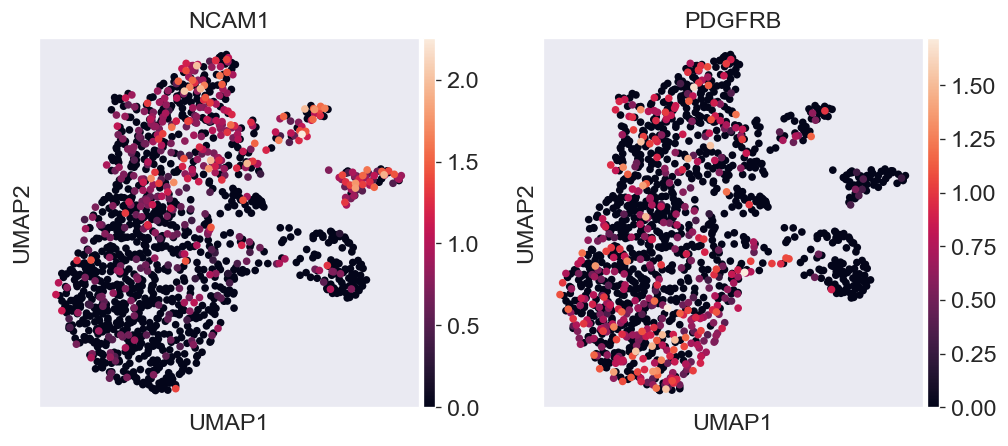

In [41]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["NCAM1", "PDGFRB"], ncols=4)

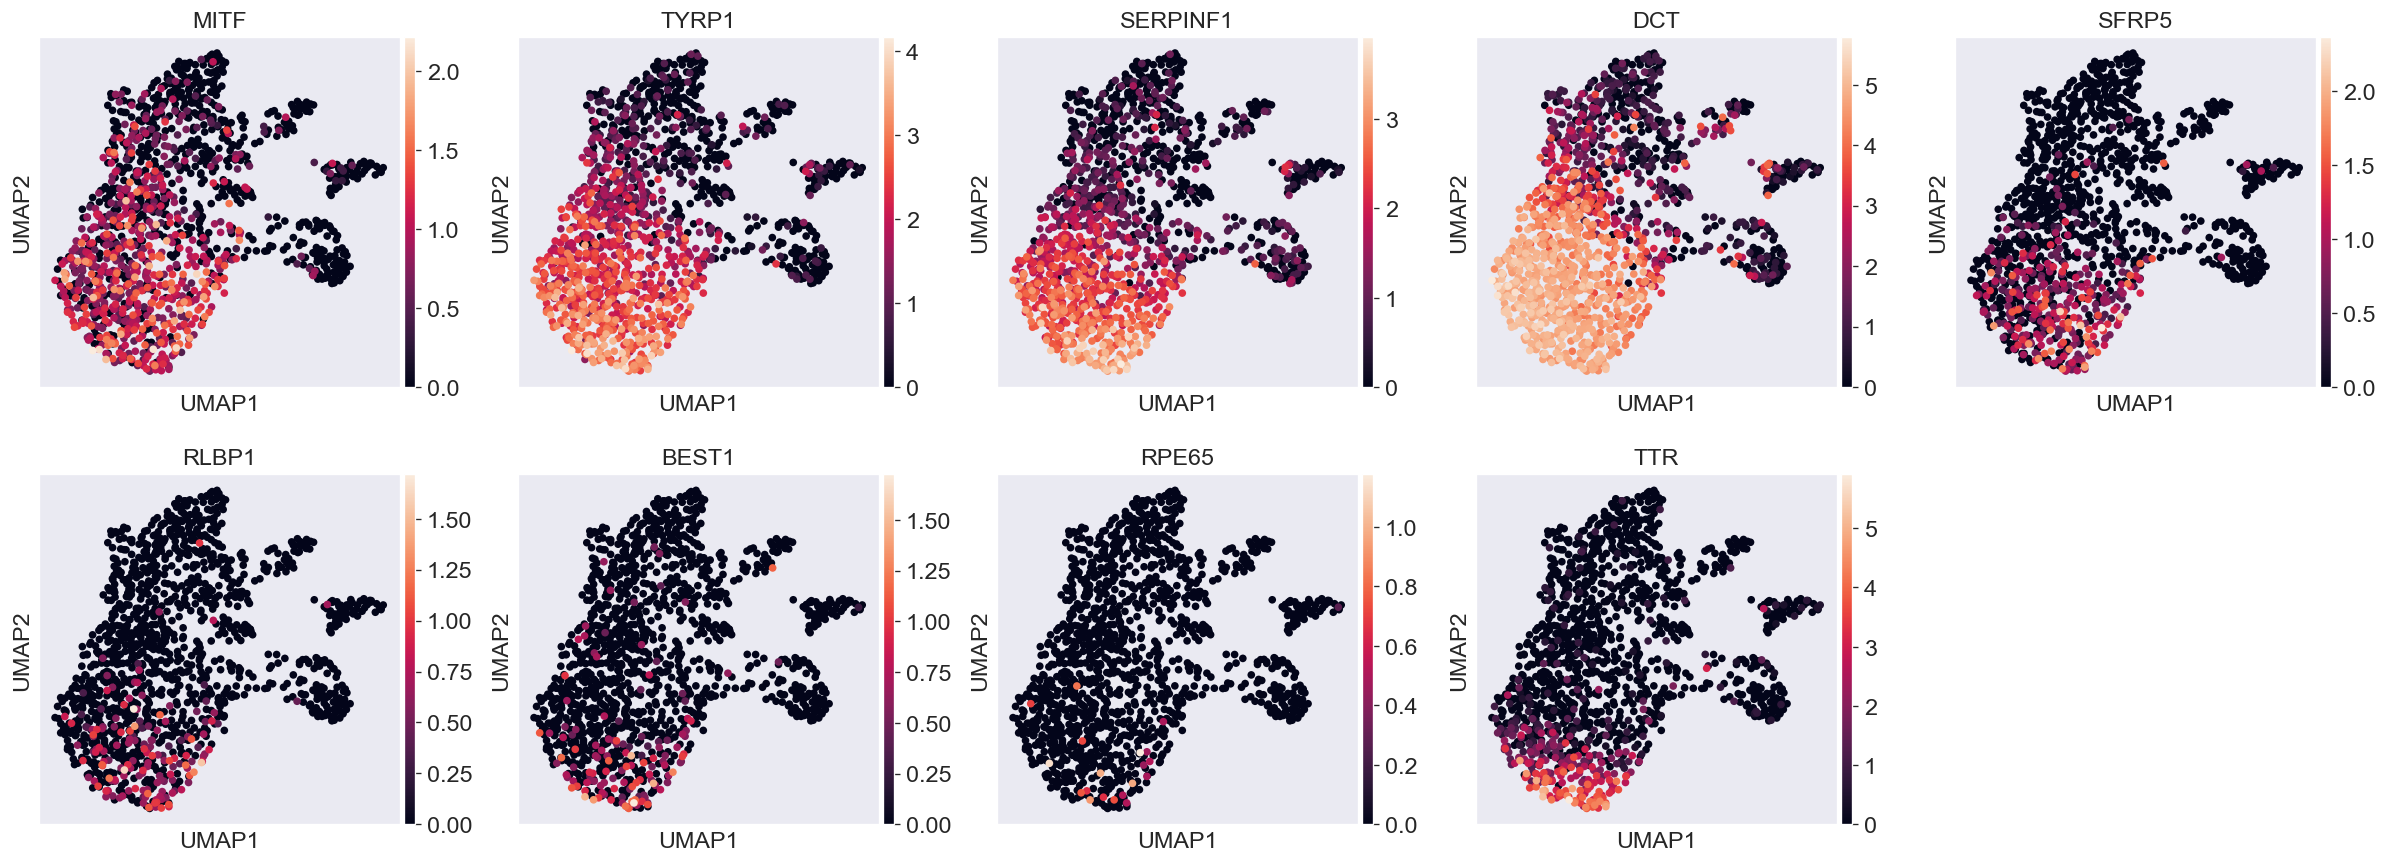

In [42]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["MITF", "TYRP1", "SERPINF1", "DCT", "SFRP5",
                                                 "RLBP1", "BEST1", "RPE65", "TTR"], ncols=5)

In [43]:
sc.tl.rank_genes_groups(adata_raw_norm, 'louvain', method='wilcoxon', n_genes=20, use_raw=True)
markers = pd.DataFrame(adata_raw_norm.uns['rank_genes_groups']['names'])

In [44]:
markers.head(10)

,0,1,2,3,4,5,6,7,8,9
0,SFRP2,DCT,PAX6,CTSV,SERPINF1,TXNIP,TOP2A,LIM2,STMN2,RPL12
1,NR2F1,PMEL,LMO4,CALD1,TTR,MIR205HG,TUBA1B,S100A4,TUBB3,RPS3A
2,DAPL1,SERPINF1,NKAIN4,TPM1,TYRP1,S100A11,HMGN2,CRYAB,TUBB2B,RPL41
3,SCN3A,ELN,SNCA,SLC7A8,PMEL,S100A10,HMGB2,CRYBB2,MAP1B,RPS23
4,LMAN1,APOE,PTMA,B2M,CST3,SAT1,CENPF,ALDH1A1,TUBA1A,RPS12
5,HMX1,TYRP1,PCDH9,CRYAB,PTGDS,KRT19,DEK,BHMT,BEX1,RPS19
6,PTH2,PTGDS,PVALB,HSP90AA1,COL8A1,TMSB4X,TYMS,CADM1,BASP1,RPL11
7,MAB21L1,IGFBP5,GJA1,MYL9,APOE,PERP,SMC4,CALM2,NNAT,RPS8
8,COL1A2,IGFBP7,AGA,ANXA2,ELN,DSP,CDK1,GAPDH,DCX,RPL35A
9,MSI2,ATP1B1,GAS1,CKAP4,CD63,KRT17,NUSAP1,SPARCL1,CRABP1,RPL39


In [45]:
from miscalg import enrichment
Xgen = adata_raw_norm.X.toarray().T
enrichment_score = enrichment.enrichment_score(Xgen, np.array([int(i) for i in adata_raw_norm.obs["louvain"]]))
emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(adata_raw_norm.var.index), n_enriched=15)

edf = pd.DataFrame(emarkers)
edf.head(15)

,0,1,2,3,4,5,6,7,8,9
0,ATP1A2,CD53,LINC01099,CTHRC1,TTR,S100A14,RAD51AP1,SPARCL1,STMN2,HIST1H4F
1,CRB1,LINC01933,LINC01474,KIF20A,ADTRP,KRT5,ESCO2,CRYBB3,ONECUT2,HIST1H3G
2,VSX2,KCNJ3,CYTIP,SBSPON,RDH5,TACSTD2,HIST1H3B,LINC01320,LINC00599,HIST1H3B
3,BHLHE22,TFPI2,PLPPR5,TMEM88,BEST1,RAB25,CKAP2L,LIM2,SCG3,HIST1H3F
4,PRSS35,LRRC39,AC093866.1,RBP7,SLC4A5,MIR205HG,HJURP,BHMT,SYT4,HIST1H3H
5,LRRC4C,FIBCD1,CDH18,TUBB6,SLC6A13,COL17A1,BRCA1,CRYBB2,ONECUT1,HIST1H3D
6,PTH2,ATP6V1C2,NPFFR2,TNNC1,CSF1R,CLDN7,HIST1H1B,FOXE3,TH,AC079145.1
7,NRCAM,PRPH,LYPD1,PNOC,OC90,WNT6,KIF11,CRYGS,NHLH1,KIF18B
8,LINC02500,TNFRSF14,CLMP,ACTC1,GNGT1,IRF6,TTK,GJA8,STMN4,HIST1H4H
9,FGF19,RAB27A,AGA,CDKN3,BCO1,WNT4,KIF23,PITX3,ELAVL4,ROBO3


In [46]:
louvain2name = {'0':"RetProg", '1':"MidRPE", '2':"EarlyRPE", '3': "MidRPE", '4':"LateRPE",
                '5':"Mesenchyme", '6':"RetProg", '7': "Lens", '8':"NeuralRet", '9': "RetProg"}

In [47]:
adata.obs["cell_type"] = [louvain2name[i] for i in adata.obs["louvain"]]

... storing 'cell_type' as categorical


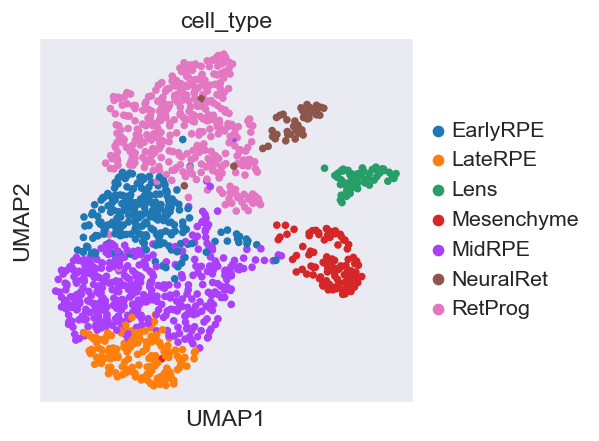

In [48]:
sc.pl.umap(adata, color=["cell_type"])

In [49]:
adata_raw_norm.obs["cell_type"] = adata.obs["cell_type"]

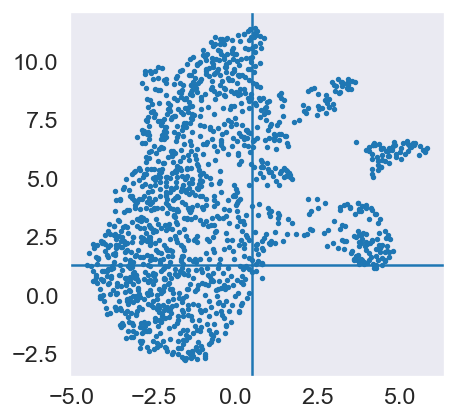

In [50]:
em = adata_raw_norm.obsm["X_umap"]
plt.scatter(em[:, 0], em[:, 1], s=5)
plt.axvline(0.5)
plt.axhline(1.3)

In [51]:
nct = []
for x,y,ct in zip(em[:, 0], em[:, 1], adata_raw_norm.obs["cell_type"]):
    if x>0.5 and y>1.3 and ct=="MidRPE":
        nct.append("EMT-RPE")
    else:
        nct.append(ct)
adata_raw_norm.obs["cell_type"] = nct

... storing 'cell_type' as categorical


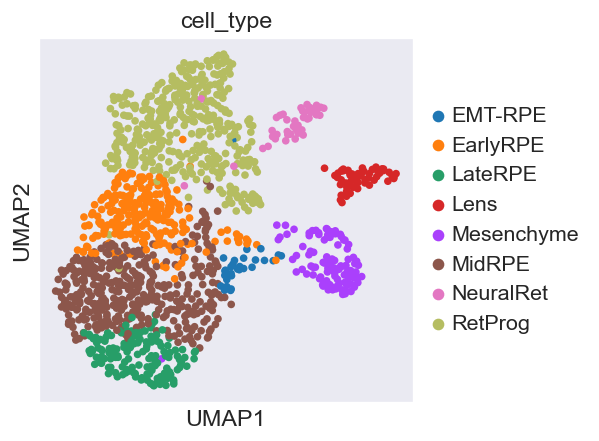

In [52]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["cell_type"], ncols=3)

In [53]:
n2n = {'EarlyRPE':0, 'LateRPE':2, 'MidRPE':1, 'Mesenchyme':3, 'RetProg':5, 'NeuralRet':4, "Lens":6, 'EMT-RPE':7, }

In [54]:
from miscalg import enrichment
Xgen = adata_raw_norm.X.toarray().T
enrichment_score = enrichment.enrichment_score(Xgen, np.array([n2n[i] for i in adata_raw_norm.obs["cell_type"]]))
emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(adata_raw_norm.var.index), n_enriched=20)
edf = pd.DataFrame(emarkers)
edf.columns = ["EarlyRPE", "MidRPE", "LateRPE", "Mesenchyme", "NeuralRet", "RetProg", "Lens", "EMT-RPE"]
edf.head(20)

,EarlyRPE,MidRPE,LateRPE,Mesenchyme,NeuralRet,RetProg,Lens,EMT-RPE
0,LINC01099,CD53,TTR,S100A14,STMN2,BHLHE22,SPARCL1,C5orf46
1,LINC01474,SLC35D3,ADTRP,KRT5,ONECUT2,PTH2,CRYBB3,ACTA2
2,CYTIP,ADAM28,RDH5,TACSTD2,LINC00599,ATP1A2,LINC01320,ACTC1
3,PLPPR5,FIBCD1,BEST1,RAB25,SCG3,VSX2,LIM2,DKK2
4,AC093866.1,CHRNA3,SLC4A5,MIR205HG,SYT4,CRB1,BHMT,CTHRC1
5,CDH18,GNG11,SLC6A13,COL17A1,ONECUT1,PTPRO,CRYBB2,MGP
6,NPFFR2,KCNJ3,CSF1R,CLDN7,TH,LRRC4C,FOXE3,COL1A1
7,LYPD1,TMEM151A,OC90,WNT6,NHLH1,NRCAM,CRYGS,SBSPON
8,CLMP,TYR,GNGT1,IRF6,STMN4,PRSS35,GJA8,NRP2
9,AGA,RAB27A,BCO1,WNT4,ELAVL4,FEZF2,PITX3,SERTAD4-AS1


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


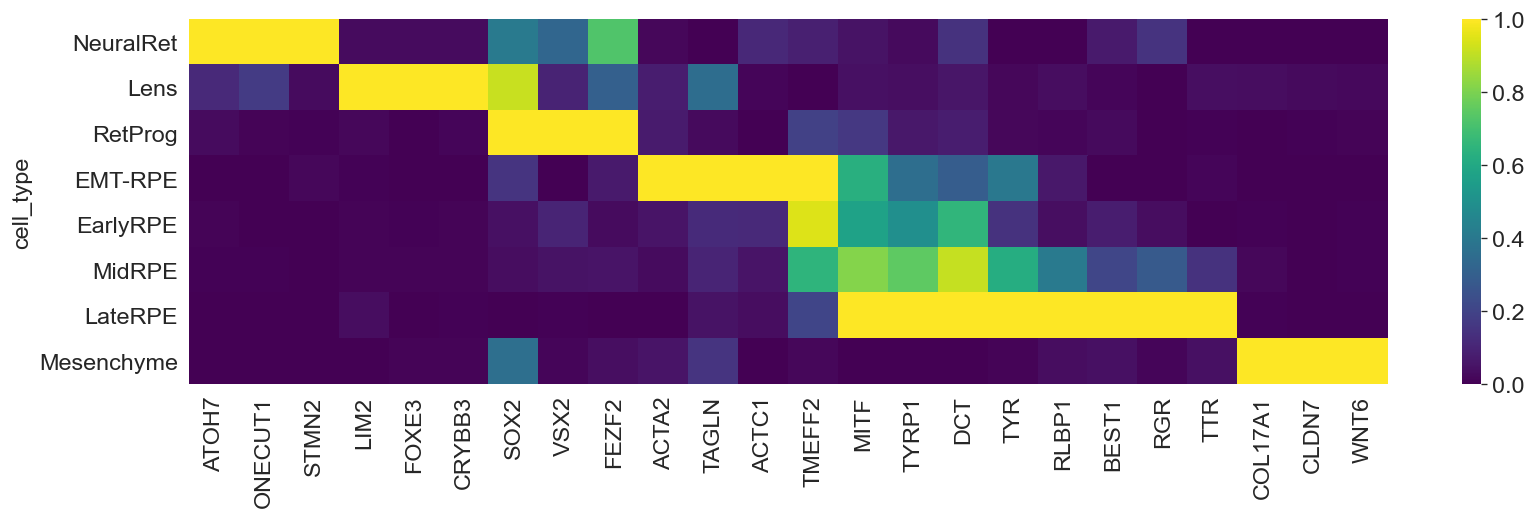

In [55]:
genes = ["STMN2", "NEUROD4", "NEUROD1", "RCVRN", "ONECUT1", "ATOH7",
         "LIM2", "FOXE3", "CRYBB3", "CRYBB2", "CRYGS", "PITX3",
        "SOX2", "HES5", "FGF19", "VSX2", "CRB1", "FEZF2",
         "TMEFF2", "MITF", "DCT", "TYRP1", "PMEL", "TYR", "RLBP1", "BEST1",
        "RPE65", "TTR", "RGR", "SLC6A13", "SFRP5", "RDH5",
        "S100A14", "KRT5", "COL17A1", "CLDN7", "WNT6", "WNT4"]
genes = ["ATOH7", "ONECUT1", "STMN2", 
        "LIM2", "FOXE3", "CRYBB3",
        "SOX2", "VSX2", "FEZF2",
        "ACTA2", "TAGLN", "ACTC1",
         "TMEFF2", "MITF", "TYRP1",
         "DCT", "TYR", "RLBP1",
         "BEST1", "RGR", "TTR",
        "COL17A1", "CLDN7", "WNT6"]
X = pd.DataFrame(adata_raw_norm[:, genes].X.toarray())
X.index = adata_raw_norm.obs["cell_type"]
X.columns = genes
X = X.groupby(X.index).mean()

X = X.loc[["NeuralRet", "Lens", "RetProg", "EMT-RPE",
           "EarlyRPE", "MidRPE", "LateRPE", "Mesenchyme"]]

plt.figure(None, (16, 4))
sns.heatmap((X - X.min()) / (X.max() - X.min()), cmap='viridis', rasterized=True)
plt.show()

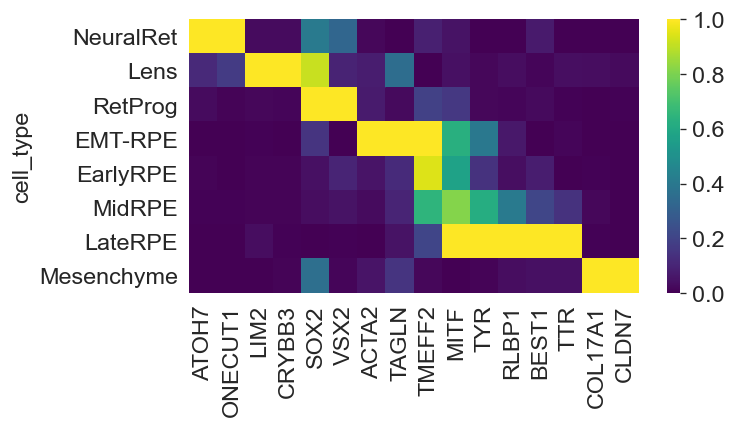

In [56]:
genes = ["ATOH7", "ONECUT1",
        "LIM2", "CRYBB3",
        "SOX2", "VSX2",
        "ACTA2", "TAGLN", 
         "TMEFF2", "MITF", 
         "TYR", "RLBP1", 
         "BEST1", "TTR",
        "COL17A1", "CLDN7"]
X = pd.DataFrame(adata_raw_norm[:, genes].X.toarray())
X.index = adata_raw_norm.obs["cell_type"]
X.columns = genes
X = X.groupby(X.index).mean()

X = X.loc[["NeuralRet", "Lens", "RetProg", "EMT-RPE",
           "EarlyRPE", "MidRPE", "LateRPE", "Mesenchyme"]]

plt.figure(None, (6, 3))
sns.heatmap((X - X.min()) / (X.max() - X.min()), cmap='viridis', rasterized=True)
plt.show()

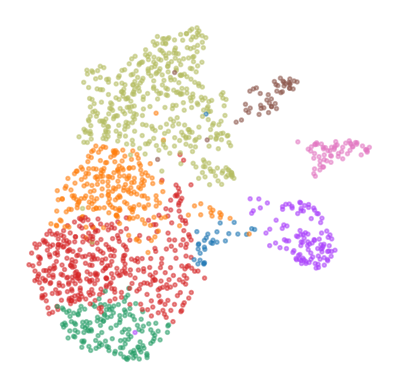

In [57]:
adata_raw.obs["cell_type"] = adata.obs["cell_type"]
adata_raw.obs["cell_type"] = [i for i in adata_raw_norm.obs["cell_type"]]
adata_raw.uns["cell_type_colors"] = adata_raw_norm.uns["cell_type_colors"]

n2n = {'EMT-RPE':'#1f77b4',
 'EarlyRPE': '#ff7f0e',
 'LateRPE': '#279e68',
 'MidRPE': '#d62728',
 'Mesenchyme': '#aa40fc',
 'NeuralRet': '#8c564b',
 'Lens':'#e377c2',
 'RetProg':'#b5bd61'}

em = adata_raw_norm.obsm["X_umap"]
plt.scatter(em[:, 0], em[:, 1], c=[n2n[i] for i in adata_raw_norm.obs["cell_type"]], 
            s=5, alpha=0.5, rasterized=False)
plt.axis("off")
plt.show()